# Image Classification: City Identification

To start we import the fast.ai.vision library.

In [ ]:
# if this fails, its either already been run or you need to go to the top menu bar and select "Runtime" > "Factory Reset Runtime"
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 727kB 18.8MB/s 
     |████████████████████████████████| 1.2MB 55.2MB/s 
     |████████████████████████████████| 194kB 40.5MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 61kB 10.9MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
Mounted at /content/gdrive


## Skyline

Mount your google drive to this colab notebook

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
classes = "nyc", "london"
path = Path("/content/drive/Shared drives/Team_2_cs121S21/code/data/streets_database/500/")

In [ ]:
fnames = get_image_files(path)
failed = verify_images(fnames)
failed.map(Path.unlink)

(#1) [None]

## Data block

Fast.ai provides a class called DataBlock for storing and processing data used in training.

In [ ]:
# create DataBlock
skylines = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 get_y=parent_label,
                 splitter=RandomSplitter(seed=42),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
# read data
dls = skylines.dataloaders(path)

Let's parse this code to understand what is going on.

The arguments to the constructor are:
* **blocks = (ImageBlock, CategoryBlock)** specifies the components of our data; i.e. images and, for each image, a category, i.e. breed.
* **get_items=get_image_files** specifies how to read the data
* **get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name')** specifies how to determine the category name; i.e. by applying this regular expression to the image file name
* **splitter=RandomSplitter(seed=42)** specifies how to split the data into training and validation set; default percentages are 75\% training and 25\% validation
* **item_tfms=Resize(460)** specifies how to resize the data
* **batch_tfms=aug_transforms(size=224, min_scale=0.75)** specifies transforms to augment the data

We'll talk about the last two (item_tfs and batch_tfms) next week.

### Checking and Debugging a DataBlock

We can double check the data using the `show_batch` method.

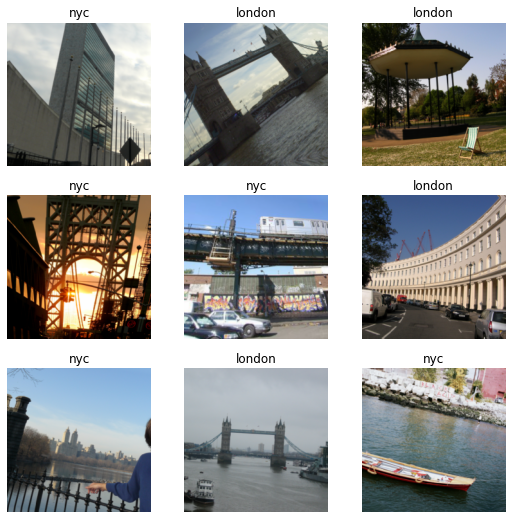

In [ ]:
dls.show_batch(nrows=3, ncols=3)

## Learner

Fast.ai provides learner classes for combining the datablock and the neural net architecture. We are going to use a convolutional neural net (cnn) architecture called resnet34. This model is initially trained for the imagenet dataset.

In [ ]:
# create Learner
learn = cnn_learner(dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0012022644514217973)

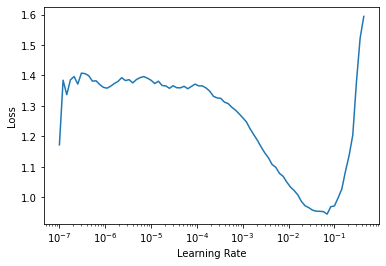

In [ ]:
#find learning rate for initial training (head)
learn.lr_find()

In [ ]:
# train head 
learn.fit_one_cycle(3, lr_max=.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.265028,14.065669,0.510204,00:38
1,3.339172,39.898518,0.540816,00:37
2,3.166116,3.511825,0.581633,00:37


In [ ]:
learn.save("/content/drive/Shared drives/Team_2_cs121S21/code/streets_database_nyc_tokyo_head")

Path('/content/drive/Shared drives/Team_2_cs121S21/code/streets_database_nyc_tokyo_head.pth')

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=6.918309736647643e-06)

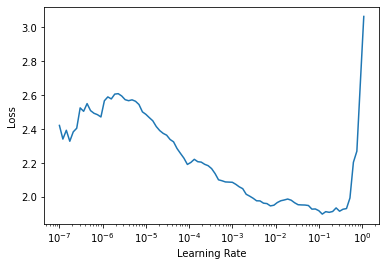

In [ ]:
learn.load("/content/drive/Shared drives/Team_2_cs121S21/code/streets_database_nyc_tokyo_head")
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(50, lr_max=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,2.483162,3.749751,0.561224,00:37
1,2.420460,2.997796,0.530612,00:37
2,2.165455,1.753587,0.561224,00:37
3,2.069618,1.856629,0.438776,00:37
4,1.950891,1.904781,0.448980,00:37
5,1.846119,2.411047,0.469388,00:37
6,1.733600,2.382891,0.448980,00:37
7,1.609826,2.282891,0.459184,00:37
8,1.537957,2.435300,0.418367,00:37
9,1.451931,2.221148,0.428571,00:37


epoch,train_loss,valid_loss,error_rate,time
0,2.483162,3.749751,0.561224,00:37
1,2.420460,2.997796,0.530612,00:37
2,2.165455,1.753587,0.561224,00:37
3,2.069618,1.856629,0.438776,00:37
4,1.950891,1.904781,0.448980,00:37
5,1.846119,2.411047,0.469388,00:37
6,1.733600,2.382891,0.448980,00:37
7,1.609826,2.282891,0.459184,00:37
8,1.537957,2.435300,0.418367,00:37
9,1.451931,2.221148,0.428571,00:37


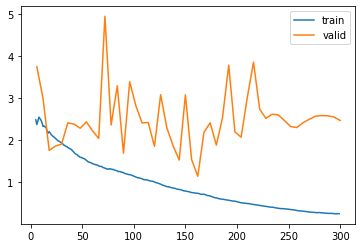

In [ ]:
learn.recorder.plot_loss()


In [ ]:
## now choose good #epochs, reload your saved model and train again for the desired number of epochs

## Model Interpretation

We can look at the classes that were confused with others. The confusion matrix entry i,j shows how many instances of class i were interpreted as class j.

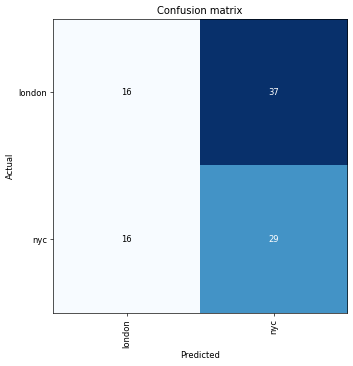

In [ ]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In this case, a confusion matrix is very hard to read. We have 37 different breeds of pet, which means we have 37×37 entries in this giant matrix! Instead, we can use the `most_confused` method, which just shows us the cells of the confusion matrix with the most incorrect predictions (here, with at least 5 or more):

In [ ]:
interp.most_confused(min_val=5)

[('beijing', 'dubai', 8)]

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner